In [1]:
import time
import pandas as pd, numpy as np
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn import metrics

import joblib
import pickle

In [2]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
subm = pd.read_csv('./sample_submission_most_popular.csv')

In [24]:
train.head()

,id,movie,dialogue,genres
0,0,0,I thought you were in a meeting--? <BR> I am. ...,"[drama, romance]"
1,1,1,Are you sure you're okay? You're pale. <BR> I...,[drama]
2,2,2,Go on! Get out! <BR> Mom look don't say anythi...,[comedy]
3,3,3,I could have lost my fucking hands. <BR> That ...,"[mystery, thriller]"
4,4,4,Stick with me on this Gloria. I need you... <...,"[crime, thriller]"


In [25]:
lens = train.dialogue.str.len()
lens.mean(), lens.std(), lens.max()

(247.42237300965098, 250.05271846661967, 5552)

<AxesSubplot:>

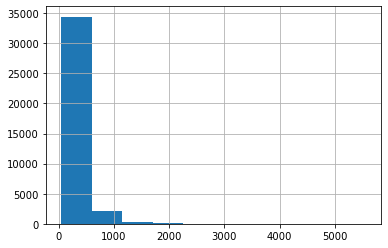

In [26]:
lens.hist()

In [27]:
train.describe()

,id,movie
count,36991.00000,36991.000000
mean,18495.00000,210.102538
std,10678.52624,129.324255
min,0.00000,0.000000
25%,9247.50000,99.000000
50%,18495.00000,203.000000
75%,27742.50000,313.500000
max,36990.00000,482.000000


In [28]:
len(train), len(test)

(36991, 9403)

```Building the model```

In [29]:
import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [9]:
%%time
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=tokenize,
                      min_df=1, max_df=1.0, strip_accents='unicode', use_idf=1,
                      smooth_idf=1, sublinear_tf=1, stop_words={'english'}, max_features=100000)
trn_term_doc = vec.fit_transform(train.dialogue)
test_term_doc = vec.transform(test.dialogue)

CPU times: user 2.58 s, sys: 40.2 ms, total: 2.62 s
Wall time: 2.62 s


In [30]:
cvec = CountVectorizer(min_df=100)
trn_term_doc = cvec.fit_transform(train.dialogue)
test_term_doc = cvec.transform(test.dialogue)

In [31]:
trn_term_doc, test_term_doc

(<36991x1091 sparse matrix of type '<class 'numpy.int64'>'
 	with 992261 stored elements in Compressed Sparse Row format>,
 <9403x1091 sparse matrix of type '<class 'numpy.int64'>'
 	with 264036 stored elements in Compressed Sparse Row format>)

In [10]:
params = {
    'ngram_range': [(1, 1), (1, 2), (1, 3)],
    'min_df': [1, 3, 10, 20, 50, 100],
    'max_df': [0.1, 0.25, 0.5, 0.75, 0.9, 1.0],
    'max_features': [1000, 10000, 100000],
    'C': [1, 10]
}

In [32]:
train['genres'] = train['genres'].apply(ast.literal_eval)

ValueError: malformed node or string: ['drama', 'romance']

In [33]:
genres_labels = np.array(train['genres'])
genres_arr = np.concatenate(genres_labels)
(genres, genres_counts) = np.unique(genres_arr, return_counts=True)
genres

array(['action', 'adventure', 'animation', 'biography', 'comedy', 'crime',
       'drama', 'family', 'fantasy', 'history', 'horror', 'music',
       'musical', 'mystery', 'romance', 'sci-fi', 'sport', 'thriller',
       'war', 'western'], dtype='<U9')

In [34]:
y = np.zeros((genres_labels.shape[0], len(genres)))
for i in range(train.shape[0]):
    for j in range(len(train['genres'][i])):
        y[i][np.where(genres == train['genres'][i][j])[0][0]] = 1

In [157]:
%%time
f1_scores = []
iterations = 1
max_iterations = 648

for _, ngram in enumerate(params['ngram_range']):
    for _, min_df in enumerate(params['min_df']):
        for _, max_df in enumerate(params['max_df']):
            for _, max_features in enumerate(params['max_features']):
                for _, c in enumerate(params['C']):
                    start = time.time()
                    vec = TfidfVectorizer(ngram_range=ngram, tokenizer=tokenize,
                                          min_df=min_df, max_df=max_df, strip_accents='unicode', use_idf=1,
                                          smooth_idf=1, sublinear_tf=1, stop_words={'english'}, max_features=max_features)

                    trn_term_doc = vec.fit_transform(train.dialogue)
                    x = trn_term_doc
                    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

                    preds = np.zeros((X_test.shape[0], len(genres)))

                    for i in range(len(genres)):
                        m = LogisticRegression(C=c, max_iter=10000)
                        m.fit(X_train, y_train[:, i])
                        preds[:,i] = m.predict_proba(X_test)[:,1]

                    y_test_prediction = pd.DataFrame(preds, columns=genres)

                    y_test_pred = np.zeros((X_test.shape[0], len(genres)))
                    for movie in y_test_prediction.index:
                        for genre in range(len(genres)):
                            if y_test_prediction.loc[movie][genre] > 0.28:
                                y_test_pred[movie][genre] = 1
                    f1_scores.append(metrics.f1_score(y_test, y_test_pred, average="samples"))
                    end = time.time()
                    print(f'{iterations}/{max_iterations}({iterations / max_iterations * 100}%), last operation: {end - start}')
                    iterations += 1
                    print(f'ngram: {ngram}, min_df: {min_df}, max_df: {max_df}, max_features: {max_features}, c: {c}, accuracy: {metrics.accuracy_score(y_test_pred, y_test)}, f1: {metrics.f1_score(y_test, y_test_pred, average="samples")}')
                    print(f'top result: {np.asarray(f1_scores)[np.asarray(f1_scores).argmax()]}')

1/648(0.15432098765432098%), last operation: 13.169445991516113
ngram: (1, 1), min_df: 1, max_df: 0.1, max_features: 1000, c: 1, accuracy: 0.19516150831193405, f1: 0.6425660267260485
top result: 0.6425660267260485
2/648(0.30864197530864196%), last operation: 16.07979702949524
ngram: (1, 1), min_df: 1, max_df: 0.1, max_features: 1000, c: 10, accuracy: 0.18989052574672252, f1: 0.6361325103993032
top result: 0.6425660267260485
3/648(0.4629629629629629%), last operation: 14.483413934707642
ngram: (1, 1), min_df: 1, max_df: 0.1, max_features: 10000, c: 1, accuracy: 0.22138126773888364, f1: 0.6644682786391126
top result: 0.6644682786391126
4/648(0.6172839506172839%), last operation: 20.678941011428833
ngram: (1, 1), min_df: 1, max_df: 0.1, max_features: 10000, c: 10, accuracy: 0.24097851060954184, f1: 0.660218991412396
top result: 0.6644682786391126
5/648(0.7716049382716049%), last operation: 17.579374074935913
ngram: (1, 1), min_df: 1, max_df: 0.1, max_features: 100000, c: 1, accuracy: 0.22

40/648(6.172839506172839%), last operation: 20.05610489845276
ngram: (1, 1), min_df: 3, max_df: 0.1, max_features: 10000, c: 10, accuracy: 0.24084335721043384, f1: 0.6602524579683656
top result: 0.6739235460819459
41/648(6.327160493827161%), last operation: 15.314476013183594
ngram: (1, 1), min_df: 3, max_df: 0.1, max_features: 100000, c: 1, accuracy: 0.22354372212461143, f1: 0.6645977470142899
top result: 0.6739235460819459
42/648(6.481481481481481%), last operation: 21.413544178009033
ngram: (1, 1), min_df: 3, max_df: 0.1, max_features: 100000, c: 10, accuracy: 0.2466549533720773, f1: 0.6627301630207427
top result: 0.6739235460819459
43/648(6.635802469135803%), last operation: 13.80506706237793
ngram: (1, 1), min_df: 3, max_df: 0.25, max_features: 1000, c: 1, accuracy: 0.19813488309230978, f1: 0.6494331065759636
top result: 0.6739235460819459
44/648(6.790123456790123%), last operation: 17.217416048049927
ngram: (1, 1), min_df: 3, max_df: 0.25, max_features: 1000, c: 10, accuracy: 0.1

79/648(12.191358024691358%), last operation: 13.845755815505981
ngram: (1, 1), min_df: 10, max_df: 0.25, max_features: 1000, c: 1, accuracy: 0.19813488309230978, f1: 0.6494331065759636
top result: 0.6739235460819459
80/648(12.345679012345679%), last operation: 17.29661273956299
ngram: (1, 1), min_df: 10, max_df: 0.25, max_features: 1000, c: 10, accuracy: 0.19597242870658196, f1: 0.6459333843912841
top result: 0.6739235460819459
81/648(12.5%), last operation: 14.853730916976929
ngram: (1, 1), min_df: 10, max_df: 0.25, max_features: 10000, c: 1, accuracy: 0.2185430463576159, f1: 0.6655090670768465
top result: 0.6739235460819459
82/648(12.654320987654321%), last operation: 20.743666172027588
ngram: (1, 1), min_df: 10, max_df: 0.25, max_features: 10000, c: 10, accuracy: 0.22922016488714692, f1: 0.6570966260991941
top result: 0.6739235460819459
83/648(12.808641975308642%), last operation: 14.761852979660034
ngram: (1, 1), min_df: 10, max_df: 0.25, max_features: 100000, c: 1, accuracy: 0.218

117/648(18.055555555555554%), last operation: 14.207860946655273
ngram: (1, 1), min_df: 20, max_df: 0.25, max_features: 10000, c: 1, accuracy: 0.21259629679686445, f1: 0.6626212894492391
top result: 0.6739235460819459
118/648(18.209876543209877%), last operation: 19.904288053512573
ngram: (1, 1), min_df: 20, max_df: 0.25, max_features: 10000, c: 10, accuracy: 0.20948776861738072, f1: 0.6511190915975347
top result: 0.6739235460819459
119/648(18.3641975308642%), last operation: 14.26558780670166
ngram: (1, 1), min_df: 20, max_df: 0.25, max_features: 100000, c: 1, accuracy: 0.21259629679686445, f1: 0.6626212894492391
top result: 0.6739235460819459
120/648(18.51851851851852%), last operation: 19.75548791885376
ngram: (1, 1), min_df: 20, max_df: 0.25, max_features: 100000, c: 10, accuracy: 0.20948776861738072, f1: 0.6511190915975347
top result: 0.6739235460819459
121/648(18.67283950617284%), last operation: 13.87776517868042
ngram: (1, 1), min_df: 20, max_df: 0.5, max_features: 1000, c: 1, 

155/648(23.919753086419753%), last operation: 13.873524904251099
ngram: (1, 1), min_df: 50, max_df: 0.25, max_features: 100000, c: 1, accuracy: 0.20354101905662927, f1: 0.6566156516217335
top result: 0.6739235460819459
156/648(24.074074074074073%), last operation: 18.144031047821045
ngram: (1, 1), min_df: 50, max_df: 0.25, max_features: 100000, c: 10, accuracy: 0.2012434112717935, f1: 0.6495504540510622
top result: 0.6739235460819459
157/648(24.228395061728396%), last operation: 13.961562871932983
ngram: (1, 1), min_df: 50, max_df: 0.5, max_features: 1000, c: 1, accuracy: 0.19691850250033788, f1: 0.6489607132667005
top result: 0.6739235460819459
158/648(24.382716049382715%), last operation: 17.68556499481201
ngram: (1, 1), min_df: 50, max_df: 0.5, max_features: 1000, c: 10, accuracy: 0.20097310447357752, f1: 0.6477959269485151
top result: 0.6739235460819459
159/648(24.537037037037038%), last operation: 14.347923040390015
ngram: (1, 1), min_df: 50, max_df: 0.5, max_features: 10000, c: 1

193/648(29.78395061728395%), last operation: 14.154581069946289
ngram: (1, 1), min_df: 100, max_df: 0.5, max_features: 1000, c: 1, accuracy: 0.19664819570212191, f1: 0.6482447220452356
top result: 0.6739235460819459
194/648(29.938271604938272%), last operation: 17.71200680732727
ngram: (1, 1), min_df: 100, max_df: 0.5, max_features: 1000, c: 10, accuracy: 0.19840518989052575, f1: 0.6469010183701357
top result: 0.6739235460819459
195/648(30.09259259259259%), last operation: 13.938955068588257
ngram: (1, 1), min_df: 100, max_df: 0.5, max_features: 10000, c: 1, accuracy: 0.19718880929855387, f1: 0.6496734865500916
top result: 0.6739235460819459
196/648(30.246913580246915%), last operation: 18.074394941329956
ngram: (1, 1), min_df: 100, max_df: 0.5, max_features: 10000, c: 10, accuracy: 0.1988106500878497, f1: 0.6470731780570947
top result: 0.6739235460819459
197/648(30.401234567901238%), last operation: 13.91604995727539
ngram: (1, 1), min_df: 100, max_df: 0.5, max_features: 100000, c: 1,

231/648(35.648148148148145%), last operation: 20.698827981948853
ngram: (1, 2), min_df: 1, max_df: 0.5, max_features: 10000, c: 1, accuracy: 0.19151236653601839, f1: 0.6402200426055001
top result: 0.6739235460819459
232/648(35.80246913580247%), last operation: 32.645177125930786
ngram: (1, 2), min_df: 1, max_df: 0.5, max_features: 10000, c: 10, accuracy: 0.19921611028517366, f1: 0.6292978244593327
top result: 0.6739235460819459
233/648(35.95679012345679%), last operation: 33.82823300361633
ngram: (1, 2), min_df: 1, max_df: 0.5, max_features: 100000, c: 1, accuracy: 0.19272874712799026, f1: 0.6357284446418113
top result: 0.6739235460819459
234/648(36.11111111111111%), last operation: 59.04473328590393
ngram: (1, 2), min_df: 1, max_df: 0.5, max_features: 100000, c: 10, accuracy: 0.24381673199080958, f1: 0.6592102750907995
top result: 0.6739235460819459
235/648(36.26543209876543%), last operation: 18.54154896736145
ngram: (1, 2), min_df: 1, max_df: 0.75, max_features: 1000, c: 1, accuracy

270/648(41.66666666666667%), last operation: 56.01578617095947
ngram: (1, 2), min_df: 3, max_df: 0.5, max_features: 100000, c: 10, accuracy: 0.24381673199080958, f1: 0.6594975296962052
top result: 0.6739235460819459
271/648(41.82098765432099%), last operation: 18.448280096054077
ngram: (1, 2), min_df: 3, max_df: 0.75, max_features: 1000, c: 1, accuracy: 0.16123800513582917, f1: 0.604877106944954
top result: 0.6739235460819459
272/648(41.9753086419753%), last operation: 25.519427061080933
ngram: (1, 2), min_df: 3, max_df: 0.75, max_features: 1000, c: 10, accuracy: 0.16015677794296526, f1: 0.6027352473628999
top result: 0.6739235460819459
273/648(42.129629629629626%), last operation: 21.4797203540802
ngram: (1, 2), min_df: 3, max_df: 0.75, max_features: 10000, c: 1, accuracy: 0.1913772131369104, f1: 0.640355625063018
top result: 0.6739235460819459
274/648(42.28395061728395%), last operation: 33.1722252368927
ngram: (1, 2), min_df: 3, max_df: 0.75, max_features: 10000, c: 10, accuracy: 0.

309/648(47.68518518518518%), last operation: 21.00776982307434
ngram: (1, 2), min_df: 10, max_df: 0.75, max_features: 10000, c: 1, accuracy: 0.19083659954047844, f1: 0.6400537824716768
top result: 0.6739235460819459
310/648(47.839506172839506%), last operation: 32.67140197753906
ngram: (1, 2), min_df: 10, max_df: 0.75, max_features: 10000, c: 10, accuracy: 0.1989458034869577, f1: 0.6299240352085331
top result: 0.6739235460819459
311/648(47.99382716049383%), last operation: 24.385864973068237
ngram: (1, 2), min_df: 10, max_df: 0.75, max_features: 100000, c: 1, accuracy: 0.1967833491012299, f1: 0.6416517032546226
top result: 0.6739235460819459
312/648(48.148148148148145%), last operation: 39.71561813354492
ngram: (1, 2), min_df: 10, max_df: 0.75, max_features: 100000, c: 10, accuracy: 0.22219218813353156, f1: 0.6443352490791334
top result: 0.6739235460819459
313/648(48.30246913580247%), last operation: 18.76936674118042
ngram: (1, 2), min_df: 10, max_df: 0.9, max_features: 1000, c: 1, ac

347/648(53.54938271604939%), last operation: 22.754868030548096
ngram: (1, 2), min_df: 20, max_df: 0.75, max_features: 100000, c: 1, accuracy: 0.1934045141235302, f1: 0.6403979945809924
top result: 0.6739235460819459
348/648(53.70370370370371%), last operation: 35.49300408363342
ngram: (1, 2), min_df: 20, max_df: 0.75, max_features: 100000, c: 10, accuracy: 0.20637924043789702, f1: 0.6340752825885952
top result: 0.6739235460819459
349/648(53.85802469135802%), last operation: 19.059463024139404
ngram: (1, 2), min_df: 20, max_df: 0.9, max_features: 1000, c: 1, accuracy: 0.16110285173672118, f1: 0.6048707783334084
top result: 0.6739235460819459
350/648(54.01234567901234%), last operation: 26.526445150375366
ngram: (1, 2), min_df: 20, max_df: 0.9, max_features: 1000, c: 10, accuracy: 0.1596161643465333, f1: 0.6026524390897955
top result: 0.6739235460819459
351/648(54.166666666666664%), last operation: 21.651623964309692
ngram: (1, 2), min_df: 20, max_df: 0.9, max_features: 10000, c: 1, acc

385/648(59.413580246913575%), last operation: 20.851123094558716
ngram: (1, 2), min_df: 50, max_df: 0.9, max_features: 1000, c: 1, accuracy: 0.16110285173672118, f1: 0.6048707783334084
top result: 0.6739235460819459
386/648(59.5679012345679%), last operation: 28.339494228363037
ngram: (1, 2), min_df: 50, max_df: 0.9, max_features: 1000, c: 10, accuracy: 0.1596161643465333, f1: 0.6026524390897955
top result: 0.6739235460819459
387/648(59.72222222222222%), last operation: 22.06255006790161
ngram: (1, 2), min_df: 50, max_df: 0.9, max_features: 10000, c: 1, accuracy: 0.18975537234761455, f1: 0.6383911811334437
top result: 0.6739235460819459
388/648(59.876543209876544%), last operation: 32.626832246780396
ngram: (1, 2), min_df: 50, max_df: 0.9, max_features: 10000, c: 10, accuracy: 0.1890796053520746, f1: 0.6247862752795852
top result: 0.6739235460819459
389/648(60.03086419753087%), last operation: 21.344331979751587
ngram: (1, 2), min_df: 50, max_df: 0.9, max_features: 100000, c: 1, accura

423/648(65.27777777777779%), last operation: 21.598533868789673
ngram: (1, 2), min_df: 100, max_df: 0.9, max_features: 10000, c: 1, accuracy: 0.18394377618597108, f1: 0.6316239646284246
top result: 0.6739235460819459
424/648(65.4320987654321%), last operation: 30.407572031021118
ngram: (1, 2), min_df: 100, max_df: 0.9, max_features: 10000, c: 10, accuracy: 0.18097040140559534, f1: 0.6226687647622909
top result: 0.6739235460819459
425/648(65.58641975308642%), last operation: 21.122923851013184
ngram: (1, 2), min_df: 100, max_df: 0.9, max_features: 100000, c: 1, accuracy: 0.18394377618597108, f1: 0.6316239646284246
top result: 0.6739235460819459
426/648(65.74074074074075%), last operation: 29.555256128311157
ngram: (1, 2), min_df: 100, max_df: 0.9, max_features: 100000, c: 10, accuracy: 0.18097040140559534, f1: 0.6226687647622909
top result: 0.6739235460819459
427/648(65.89506172839506%), last operation: 20.289870738983154
ngram: (1, 2), min_df: 100, max_df: 1.0, max_features: 1000, c: 1

462/648(71.29629629629629%), last operation: 82.0379250049591
ngram: (1, 3), min_df: 1, max_df: 0.9, max_features: 100000, c: 10, accuracy: 0.23219353966752262, f1: 0.6492873339812116
top result: 0.6739235460819459
463/648(71.4506172839506%), last operation: 26.732383012771606
ngram: (1, 3), min_df: 1, max_df: 1.0, max_features: 1000, c: 1, accuracy: 0.1533991079875659, f1: 0.5921782651881314
top result: 0.6739235460819459
464/648(71.60493827160494%), last operation: 40.33088278770447
ngram: (1, 3), min_df: 1, max_df: 1.0, max_features: 1000, c: 10, accuracy: 0.15164211379916204, f1: 0.5896354505220569
top result: 0.6739235460819459
465/648(71.75925925925925%), last operation: 39.47257614135742
ngram: (1, 3), min_df: 1, max_df: 1.0, max_features: 10000, c: 1, accuracy: 0.18637653736991486, f1: 0.63211341300948
top result: 0.6739235460819459
466/648(71.91358024691358%), last operation: 62.49408793449402
ngram: (1, 3), min_df: 1, max_df: 1.0, max_features: 10000, c: 10, accuracy: 0.19029

501/648(77.31481481481481%), last operation: 31.92299795150757
ngram: (1, 3), min_df: 3, max_df: 1.0, max_features: 10000, c: 1, accuracy: 0.18610623057169887, f1: 0.6322260408420701
top result: 0.6739235460819459
502/648(77.46913580246914%), last operation: 46.2664692401886
ngram: (1, 3), min_df: 3, max_df: 1.0, max_features: 10000, c: 10, accuracy: 0.19178267333423435, f1: 0.6256291605257682
top result: 0.6739235460819459
503/648(77.62345679012346%), last operation: 47.69133281707764
ngram: (1, 3), min_df: 3, max_df: 1.0, max_features: 100000, c: 1, accuracy: 0.18124070820381133, f1: 0.6229036742416929
top result: 0.6739235460819459
504/648(77.77777777777779%), last operation: 86.8505551815033
ngram: (1, 3), min_df: 3, max_df: 1.0, max_features: 100000, c: 10, accuracy: 0.23273415326395458, f1: 0.650281998639885
top result: 0.6739235460819459
505/648(77.9320987654321%), last operation: 23.058294773101807
ngram: (1, 3), min_df: 10, max_df: 0.1, max_features: 1000, c: 1, accuracy: 0.15

540/648(83.33333333333334%), last operation: 60.64361000061035
ngram: (1, 3), min_df: 10, max_df: 1.0, max_features: 100000, c: 10, accuracy: 0.2205703473442357, f1: 0.6423031211854027
top result: 0.6739235460819459
541/648(83.48765432098766%), last operation: 22.735764026641846
ngram: (1, 3), min_df: 20, max_df: 0.1, max_features: 1000, c: 1, accuracy: 0.15610217596972564, f1: 0.5959927017164481
top result: 0.6739235460819459
542/648(83.64197530864197%), last operation: 30.145627975463867
ngram: (1, 3), min_df: 20, max_df: 0.1, max_features: 1000, c: 10, accuracy: 0.15299364779024194, f1: 0.5928303267065262
top result: 0.6739235460819459
543/648(83.79629629629629%), last operation: 28.724539041519165
ngram: (1, 3), min_df: 20, max_df: 0.1, max_features: 10000, c: 1, accuracy: 0.18759291796188673, f1: 0.6336664971885948
top result: 0.6739235460819459
544/648(83.9506172839506%), last operation: 41.260579109191895
ngram: (1, 3), min_df: 20, max_df: 0.1, max_features: 10000, c: 10, accura

579/648(89.35185185185185%), last operation: 27.15171217918396
ngram: (1, 3), min_df: 50, max_df: 0.1, max_features: 10000, c: 1, accuracy: 0.18543046357615894, f1: 0.6318080306862575
top result: 0.6739235460819459
580/648(89.50617283950618%), last operation: 43.22443699836731
ngram: (1, 3), min_df: 50, max_df: 0.1, max_features: 10000, c: 10, accuracy: 0.18299770239221516, f1: 0.6178343491291187
top result: 0.6739235460819459
581/648(89.6604938271605%), last operation: 34.96749711036682
ngram: (1, 3), min_df: 50, max_df: 0.1, max_features: 100000, c: 1, accuracy: 0.18543046357615894, f1: 0.6318080306862575
top result: 0.6739235460819459
582/648(89.81481481481481%), last operation: 44.25882029533386
ngram: (1, 3), min_df: 50, max_df: 0.1, max_features: 100000, c: 10, accuracy: 0.18299770239221516, f1: 0.6178343491291187
top result: 0.6739235460819459
583/648(89.96913580246914%), last operation: 33.54628610610962
ngram: (1, 3), min_df: 50, max_df: 0.25, max_features: 1000, c: 1, accurac

617/648(95.21604938271605%), last operation: 26.999120712280273
ngram: (1, 3), min_df: 100, max_df: 0.1, max_features: 100000, c: 1, accuracy: 0.1836734693877551, f1: 0.6283507852841547
top result: 0.6739235460819459
618/648(95.37037037037037%), last operation: 36.42593789100647
ngram: (1, 3), min_df: 100, max_df: 0.1, max_features: 100000, c: 10, accuracy: 0.18083524800648737, f1: 0.6158892128279884
top result: 0.6739235460819459
619/648(95.5246913580247%), last operation: 24.266713857650757
ngram: (1, 3), min_df: 100, max_df: 0.25, max_features: 1000, c: 1, accuracy: 0.15448033518042978, f1: 0.5939593939120903
top result: 0.6739235460819459
620/648(95.67901234567901%), last operation: 32.962931871414185
ngram: (1, 3), min_df: 100, max_df: 0.25, max_features: 1000, c: 10, accuracy: 0.152317880794702, f1: 0.5899168055743269
top result: 0.6739235460819459
621/648(95.83333333333334%), last operation: 27.74177312850952
ngram: (1, 3), min_df: 100, max_df: 0.25, max_features: 10000, c: 1, a

`Best Params`
 

In [36]:
best_ngram = (1, 1)
best_min_df = 1
best_max_df = 1.0
best_max_features = 100000
best_c = 10

In [37]:
best_ngram

(1, 1)

In [16]:
trn_term_doc, test_term_doc

(<36991x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 2441538 stored elements in Compressed Sparse Row format>,
 <9403x10000 sparse matrix of type '<class 'numpy.float64'>'
 	with 651798 stored elements in Compressed Sparse Row format>)

In [38]:
x = trn_term_doc
test_x = test_term_doc

In [39]:
y[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0.])

In [40]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((29592, 1091), (29592, 20), (7399, 1091), (7399, 20))

In [42]:
def get_mdl(y):
    m = LogisticRegression(C=10)
    return m.fit(X_train, y)

In [43]:
y[:, 0]

array([0., 0., 0., ..., 0., 0., 0.])

In [44]:
models = []
preds = np.zeros((X_test.shape[0], len(genres)))

for i in range(len(genres)):
    print('fit', genres[i])
    m = LogisticRegression(max_iter=10000)
    m.fit(X_train, y_train[:, i])
    models.append(m)
#     preds[:,i] = m.predict_proba(X_test)[:,1]

fit action
fit adventure
fit animation
fit biography
fit comedy
fit crime
fit drama
fit family
fit fantasy
fit history
fit horror
fit music
fit musical
fit mystery
fit romance
fit sci-fi
fit sport
fit thriller
fit war
fit western


In [45]:

with open('vectorizer_dump.pkl', 'wb') as output_file:
    joblib.dump(cvec, output_file)

In [46]:
with open('models_dump.pkl', 'wb') as output_file:
    joblib.dump(models, output_file)

In [47]:
with open('genres_dump.pkl', 'wb') as output_file:
    joblib.dump(genres, output_file)

In [32]:
def labels_to_submission(df, num_labels=2):
    submission = pd.DataFrame(columns=['id', 'genres'], index=df.index)
    submission.id = submission.index
    
    for movie in df.index:
        submission.loc[movie, 'genres'] = ' '.join(df.loc[movie, :].nlargest(num_labels).index)
    
    return submission

In [36]:
preds.shape

(7399, 20)

In [27]:
y_test_prediction = pd.DataFrame(preds, columns=genres)

In [28]:
y_test_pred

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [116]:
%%time
f1_scores = []
for i in np.linspace(0.25, 0.35, 10):
    y_test_pred = np.zeros((X_test.shape[0], len(genres)))
    for movie in y_test_prediction.index:
        for genre in range(len(genres)):
            if y_test_prediction.loc[movie][genre] > i:
                y_test_pred[movie][genre] = 1
    f1_scores.append(metrics.f1_score(y_test, y_test_pred, average="samples"))
    print(f'limit: {i}, accuracy: {metrics.accuracy_score(y_test_pred, y_test)}, f1: {metrics.f1_score(y_test, y_test_pred, average="samples")}')
    print(f'top result: {np.asarray(f1_scores)[np.asarray(f1_scores).argmax()]}')


limit: 0.25, accuracy: 0.1697526692796324, f1: 0.6381371785548027
top result: 0.6381371785548027
limit: 0.2611111111111111, accuracy: 0.17853764022165158, f1: 0.6394755189997791
top result: 0.6394755189997791
limit: 0.2722222222222222, accuracy: 0.1858359237734829, f1: 0.6396304090857409
top result: 0.6396304090857409
limit: 0.2833333333333333, accuracy: 0.19408028111907014, f1: 0.6406379454967103
top result: 0.6406379454967103
limit: 0.29444444444444445, accuracy: 0.20070279767536153, f1: 0.6391344175639352
top result: 0.6406379454967103
limit: 0.3055555555555555, accuracy: 0.20935261521827275, f1: 0.6393667526928778
top result: 0.6406379454967103
limit: 0.31666666666666665, accuracy: 0.21462359778348425, f1: 0.6376994317121361
top result: 0.6406379454967103
limit: 0.3277777777777777, accuracy: 0.21813758616029194, f1: 0.6339547171754226
top result: 0.6406379454967103
limit: 0.33888888888888885, accuracy: 0.22259764833085552, f1: 0.6307300214314675
top result: 0.6406379454967103
limit

In [105]:
%%time
f1_scores = []
for i in range(1, 20):
    y_test_pred = np.zeros((X_test.shape[0], len(genres)))
    for movie in y_test_prediction.index:
        n_largest = y_test_prediction.loc[movie, :].nlargest(i).index
        for genre in n_largest:
            y_test_pred[movie][np.where(genres == genre)[0][0]] = 1
        
    f1_scores.append(metrics.f1_score(y_test, y_test_pred, average="samples"))
    print(f'limit: {i}, accuracy: {metrics.accuracy_score(y_test_pred, y_test)}, f1: {metrics.f1_score(y_test, y_test_pred, average="samples")}')
    print(f'top result: {np.asarray(f1_scores)[np.asarray(f1_scores).argmax()]}')

limit: 1, accuracy: 0.20489255304770915, f1: 0.5649547236112988
top result: 0.5649547236112988
limit: 2, accuracy: 0.18232193539667524, f1: 0.6134268466137638
top result: 0.6134268466137638
limit: 3, accuracy: 0.023516691444789836, f1: 0.5800083451860719
top result: 0.6134268466137638
limit: 4, accuracy: 0.0014866873901878631, f1: 0.522967818473968
top result: 0.6134268466137638
limit: 5, accuracy: 0.00013515339910798757, f1: 0.4699144535541346
top result: 0.6134268466137638
limit: 6, accuracy: 0.0, f1: 0.422851641158169
top result: 0.6134268466137638
limit: 7, accuracy: 0.0, f1: 0.3834973919174488
top result: 0.6134268466137638
limit: 8, accuracy: 0.0, f1: 0.35001981394737175
top result: 0.6134268466137638
limit: 9, accuracy: 0.0, f1: 0.3213554252208124
top result: 0.6134268466137638
limit: 10, accuracy: 0.0, f1: 0.2973896896453999
top result: 0.6134268466137638
limit: 11, accuracy: 0.0, f1: 0.275931290207663
top result: 0.6134268466137638
limit: 12, accuracy: 0.0, f1: 0.2575219836375

Generate test result

In [29]:
def prob_to_labels(df, num_labels=2):
    for movie in df.index:
        n_largest = df.loc[movie, :].nlargest(num_labels).index
        df.loc[movie, :] = 0
        
        for genre in n_largest:
            df.loc[movie, genre] = 1
            
    return df

In [30]:
prob_to_labels(y_test_prediction)

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7394,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7395,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
7396,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7397,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [31]:
y_test_prediction.head(3)

,action,adventure,animation,biography,comedy,crime,drama,family,fantasy,history,horror,music,musical,mystery,romance,sci-fi,sport,thriller,war,western
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [33]:
y_submission = labels_to_submission(y_test_prediction)

In [85]:
y_submission.head(3)

,id,genres
0,0,drama thriller
1,1,drama thriller
2,2,adventure drama


In [86]:
y_submission.to_csv('out.csv', index=False)

In [85]:
%%time
y_test_pred = np.zeros((test_x.shape[0], len(genres)))
for movie in y_test_prediction.index:
    for genre in range(len(genres)):
        if y_test_prediction.loc[movie][genre] > 0.28:
            y_test_pred[movie][genre] = 1
y_test_pred

CPU times: user 11.2 s, sys: 22 ms, total: 11.2 s
Wall time: 11.2 s


array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [190]:
result = []
for i in range(y_test_pred.shape[0]):
    test_predicted_text = []
    for j in np.where(y_test_pred[i] == 1)[0]:
        test_predicted_text.append(genres[j])
        
    result.append(' '.join(test_predicted_text))

In [191]:
result

['crime drama',
 'drama thriller',
 'drama',
 'drama',
 'action sci-fi thriller',
 'romance thriller',
 'comedy romance',
 'comedy drama',
 'drama',
 'action adventure drama',
 'drama',
 'thriller',
 'drama thriller',
 'thriller',
 'drama',
 'action sci-fi thriller',
 'drama',
 'drama',
 'thriller',
 'action drama',
 'drama',
 'thriller',
 'sci-fi thriller',
 'drama',
 'crime drama thriller',
 'drama',
 'adventure comedy drama',
 'drama',
 'comedy thriller',
 'comedy thriller',
 'action crime thriller',
 'drama',
 'crime drama thriller',
 'action sci-fi',
 'adventure thriller',
 'drama',
 'drama thriller',
 'crime mystery thriller',
 'crime drama thriller',
 'drama',
 'drama thriller',
 'drama thriller',
 'comedy drama romance',
 'action drama thriller',
 'crime drama',
 'comedy drama',
 'drama',
 'horror thriller',
 'action thriller',
 'drama thriller',
 'horror thriller',
 'comedy drama romance',
 'comedy drama',
 'action',
 'drama',
 'drama thriller',
 'drama horror thriller',
 'dra

In [192]:
subm['genres'] = result

In [193]:
subm.to_csv('./out.csv', index=False)